In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-05-14 09:19:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  25.9MB/s    in 4.8s    

2024-05-14 09:19:30 (21.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
walk_through_dir('pizza_steak')

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [ ]:
train_dir="pizza_steak/train/"
test_dir='pizza_steak/test/'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class

  random_image=random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 384, 3)


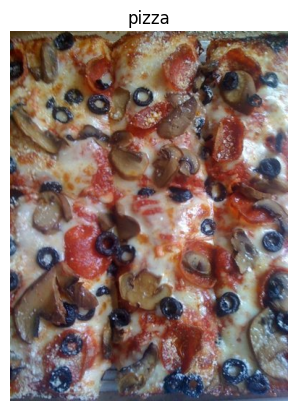

In [ ]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.random.set_seed(42)
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_data=train_datagen.flow_from_directory(train_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             seed=42)

test_data=test_datagen.flow_from_directory(test_dir,
                                           batch_size=32,
                                           target_size=(224,224),
                                           class_mode='binary',
                                           seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
from keras.applications import EfficientNetB0

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [ ]:
print(len(base_model.trainable_variables))

0


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

inputs=layers.Input(shape=(224,224,3),name='input_name')
x=base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=layers.Dense(1,activation='softmax',name='output_layer')(x)
model=tf.keras.Model(inputs,outputs)

callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best.h5', monitor='val_loss', save_best_only=True,verbose=1)
]
learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
              optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history=model.fit(train_data,
                  epochs=10,
                  validation_data=test_data,callbacks=callback)

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.00000, saving model to best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 15s 173ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 2: val_loss did not improve from 0.00000
47/47 [==============================] - 7s 145ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 0.00000
47/47 [==============================] - 6s 128ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 4: val_loss did not improve from 0.00000
47/47 [==============================] - 8s 163ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4:

In [ ]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 11s 152ms/step - loss: 0.5839 - accuracy: 0.6893 - val_loss: 0.4082 - val_accuracy: 0.8360
Epoch 2/5
47/47 [==============================] - 6s 122ms/step - loss: 0.4315 - accuracy: 0.8020 - val_loss: 0.3847 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 5s 115ms/step - loss: 0.4131 - accuracy: 0.8107 - val_loss: 0.3537 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 6s 133ms/step - loss: 0.3701 - accuracy: 0.8333 - val_loss: 0.3184 - val_accuracy: 0.8840
Epoch 5/5
47/47 [==============================] - 5s 113ms/step - loss: 0.3411 - accuracy: 0.8600 - val_loss: 0.3505 - val_accuracy: 0.8460


In [ ]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


219055592/219055592 [==============================] - 8s 0us/step
Shape after base_model: (None, 5, 5, 1536)
After GlobalAveragePooling2D(): (None, 1536)


In [ ]:
history=model.fit(train_data,
                  epochs=10,
                  validation_data=test_data)

Epoch 1/10
47/47 [==============================] - 7s 142ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/10
38/47 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4926

KeyboardInterrupt: 